In [1]:
import keras
import pandas as pd
import tensorflow as tf

2024-11-18 22:30:41.895341: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-18 22:30:41.902379: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-18 22:30:41.910434: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-18 22:30:41.912772: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-18 22:30:41.918809: I tensorflow/core/platform/cpu_feature_guar

In [2]:
print("Keras version: ", keras.__version__)
print("Tensorflow version: ", tf.__version__)
print('GPUs available: ', tf.config.experimental.list_physical_devices('GPU'))

Keras version:  3.5.0
Tensorflow version:  2.17.0
GPUs available:  []


I0000 00:00:1731990642.756660 2351975 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-11-18 22:30:42.774481: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2343] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [3]:
data_1 = pd.read_csv('mit-bih-data-clear-data.csv')
data_2 = pd.read_csv('ptb-diagnostic-clear-data.csv')
data_3 = pd.read_csv('autonomic-aging-a-dataset-clear-data.csv')


# Feature cleanup
df = pd.concat([data_1, data_2, data_3], ignore_index=True)
df.to_csv('heart_rate_final_data.csv', index=False)
columns_to_drop = [
    'patient',
    'Max_hr_slope',
    'mean_deviation',
    'outliers_percentage'
]

columns_to_reduce = [
    'vlf_power',
    'lf_power',
    'hf_power',
    'highest_heart_rate',
    'lowest_heart_rate',
    'mean_heart_rate',
    'median_heart_rate'
    
]

df[columns_to_reduce] = df[columns_to_reduce].apply(lambda x: x/100)
df.drop(columns_to_drop, axis=1, inplace=True)


df.value_counts('diagnosis')


diagnosis
0    1162
1     487
Name: count, dtype: int64

In [4]:
# Let's check for missing values

df.isnull().sum()


diagnosis                      0
highest_heart_rate             0
lowest_heart_rate              0
mean_heart_rate                0
median_heart_rate              0
standard_deviation_hr          0
minimum_hrv                    0
maximum_hrv                    0
mean_hrv                       0
median_hrv                     0
standard_deviation_hrv         0
mean_hr_slope                  0
tendency_slope                 0
standard_deviation_hr_slope    0
vlf_power                      0
lf_power                       0
hf_power                       0
mean_rr                        0
standard_deviation_rr          0
minimum_rr                     0
maximum_rr                     0
tendency_standard_deviation    0
approximation_entropy          0
sample_entropy                 2
dtype: int64

In [5]:
# Replace missing and infinite values with median
from sklearn.impute import SimpleImputer
import numpy as np
df.replace([np.inf, -np.inf], np.nan, inplace=True)
imputer = SimpleImputer(strategy='median')
df = pd.DataFrame(imputer.fit_transform(df), columns=df.columns)

In [6]:
# Resample the data

# Scenario 1: This works fine, however, this duplicates data and can lead to overfitting

# from sklearn.utils import resample
# 
# df_majority = df[df.diagnosis==1]
# df_minority = df[df.diagnosis==0]
# 
# df_minority_upsampled = resample(df_minority, replace=True, n_samples=487)
# df_upsampled = pd.concat([df_majority, df_minority_upsampled])
# df_upsampled.value_counts('diagnosis')

# Scenario 2: Let's use smote to generate synthetic data

from imblearn.over_sampling import SMOTE
smote = SMOTE()
X = df.drop(columns=['diagnosis'])
y = df['diagnosis']
X_resampled, y_resampled = smote.fit_resample(X, y)

df_upsampled = pd.concat([X_resampled, y_resampled], axis=1)




In [7]:
df_upsampled.value_counts('diagnosis')

diagnosis
0.0    1162
1.0    1162
Name: count, dtype: int64

In [8]:
X = df_upsampled.drop(columns=['diagnosis'])
y = df_upsampled['diagnosis']

X.head()

,highest_heart_rate,lowest_heart_rate,mean_heart_rate,median_heart_rate,standard_deviation_hr,minimum_hrv,maximum_hrv,mean_hrv,median_hrv,standard_deviation_hrv,...,vlf_power,lf_power,hf_power,mean_rr,standard_deviation_rr,minimum_rr,maximum_rr,tendency_standard_deviation,approximation_entropy,sample_entropy
0,1.130890,1.028571,1.081274,1.085427,2.022095,0.501672,5.685571,0.645095,0.000000,0.926676,...,4.893324,61.726334,221.350711,3.906391,2.105712,1.069444,12.505556,0.702512,1.408457,1.177573
1,1.136842,0.847059,0.963004,0.951542,5.026822,0.346988,12.139094,1.013533,0.410101,1.456583,...,17.896511,145.833155,367.016413,6.039207,3.036317,1.075000,33.636111,4.329784,1.282741,1.121386
2,0.903766,0.640950,0.758583,0.757895,4.681641,0.198950,12.804878,1.090299,0.000000,1.755623,...,42.477758,192.530932,311.683614,10.013405,6.048494,2.150000,30.163889,3.849098,1.307559,1.043753
3,0.843750,0.708197,0.755022,0.750000,2.644870,0.237619,5.898876,0.629692,0.000000,0.959347,...,16.714324,68.667396,209.085037,6.649409,2.325983,1.527778,18.361111,2.302985,1.226100,1.048676
4,0.540000,0.478936,0.507868,0.508235,0.903975,0.109323,2.010028,0.251715,0.111317,0.363182,...,7.649133,28.059190,67.323863,10.148943,5.530223,2.288889,30.327778,0.644782,1.558320,1.377851


In [9]:
from sklearn.impute import SimpleImputer
import numpy as np
X.replace([np.inf, -np.inf], np.nan, inplace=True)
imputer = SimpleImputer(strategy='median')
X = imputer.fit_transform(X)

df.head()

,diagnosis,highest_heart_rate,lowest_heart_rate,mean_heart_rate,median_heart_rate,standard_deviation_hr,minimum_hrv,maximum_hrv,mean_hrv,median_hrv,...,vlf_power,lf_power,hf_power,mean_rr,standard_deviation_rr,minimum_rr,maximum_rr,tendency_standard_deviation,approximation_entropy,sample_entropy
0,1.0,1.130890,1.028571,1.081274,1.085427,2.022095,0.501672,5.685571,0.645095,0.000000,...,4.893324,61.726334,221.350711,3.906391,2.105712,1.069444,12.505556,0.702512,1.408457,1.177573
1,1.0,1.136842,0.847059,0.963004,0.951542,5.026822,0.346988,12.139094,1.013533,0.410101,...,17.896511,145.833155,367.016413,6.039207,3.036317,1.075000,33.636111,4.329784,1.282741,1.121386
2,1.0,0.903766,0.640950,0.758583,0.757895,4.681641,0.198950,12.804878,1.090299,0.000000,...,42.477758,192.530932,311.683614,10.013405,6.048494,2.150000,30.163889,3.849098,1.307559,1.043753
3,1.0,0.843750,0.708197,0.755022,0.750000,2.644870,0.237619,5.898876,0.629692,0.000000,...,16.714324,68.667396,209.085037,6.649409,2.325983,1.527778,18.361111,2.302985,1.226100,1.048676
4,1.0,0.540000,0.478936,0.507868,0.508235,0.903975,0.109323,2.010028,0.251715,0.111317,...,7.649133,28.059190,67.323863,10.148943,5.530223,2.288889,30.327778,0.644782,1.558320,1.377851


In [10]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X = scaler.fit_transform(X)


In [11]:
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y)
smote = SMOTE()
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

In [12]:
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=5, shuffle=True)

/home/gino/miniconda3/envs/tf/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Fold 0
Confusion Matrix:
 [[337  12]
 [ 18 331]]

Classification Report:
               precision    recall  f1-score   support

         0.0       0.95      0.97      0.96       349
         1.0       0.97      0.95      0.96       349

    accuracy                           0.96       698
   macro avg       0.96      0.96      0.96       698
weighted avg       0.96      0.96      0.96       698



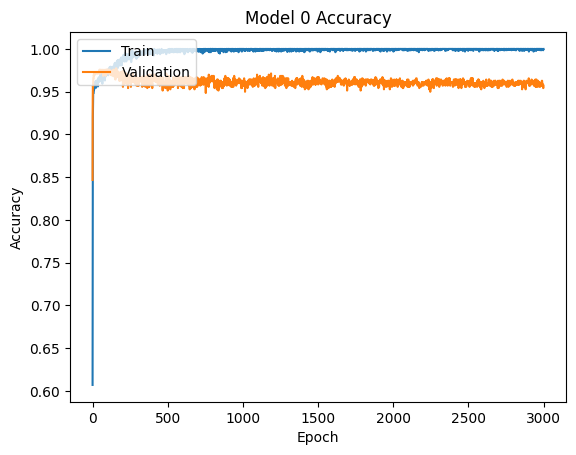

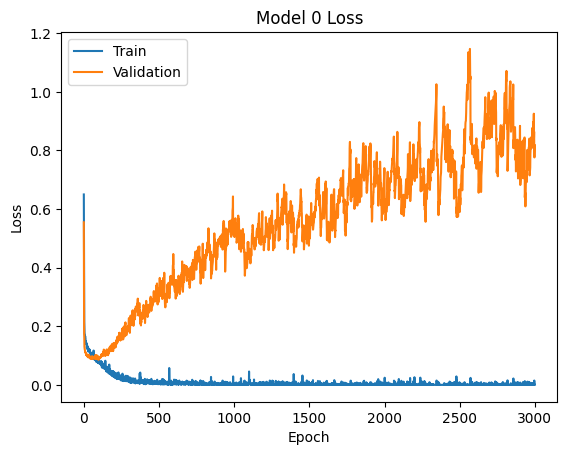

/home/gino/miniconda3/envs/tf/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Fold 1
Confusion Matrix:
 [[335  14]
 [  8 341]]

Classification Report:
               precision    recall  f1-score   support

         0.0       0.98      0.96      0.97       349
         1.0       0.96      0.98      0.97       349

    accuracy                           0.97       698
   macro avg       0.97      0.97      0.97       698
weighted avg       0.97      0.97      0.97       698



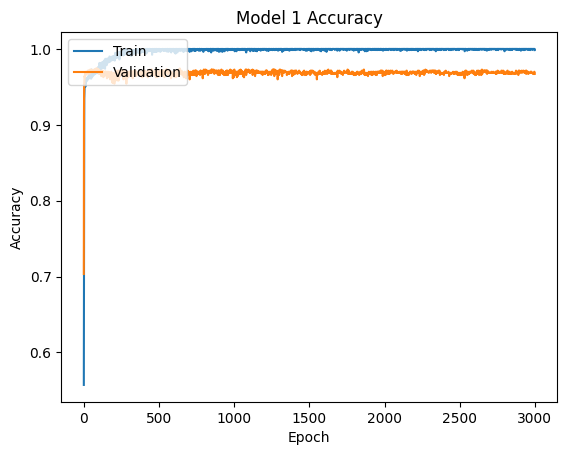

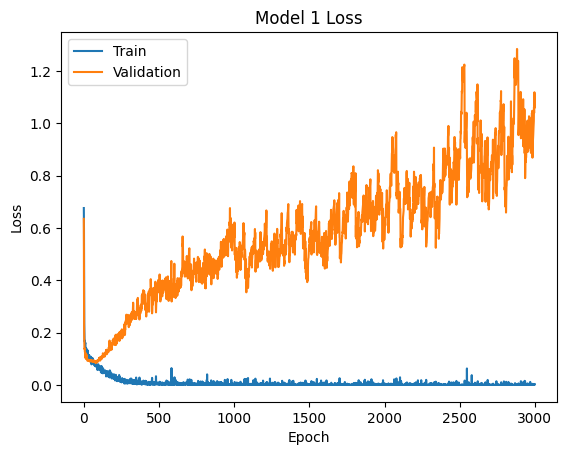

/home/gino/miniconda3/envs/tf/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Fold 2
Confusion Matrix:
 [[334  15]
 [ 12 337]]

Classification Report:
               precision    recall  f1-score   support

         0.0       0.97      0.96      0.96       349
         1.0       0.96      0.97      0.96       349

    accuracy                           0.96       698
   macro avg       0.96      0.96      0.96       698
weighted avg       0.96      0.96      0.96       698



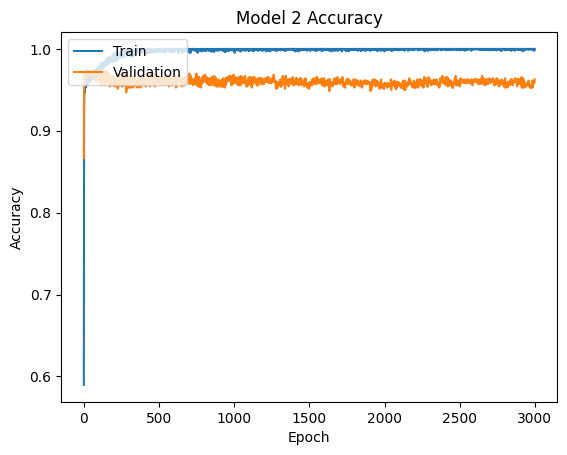

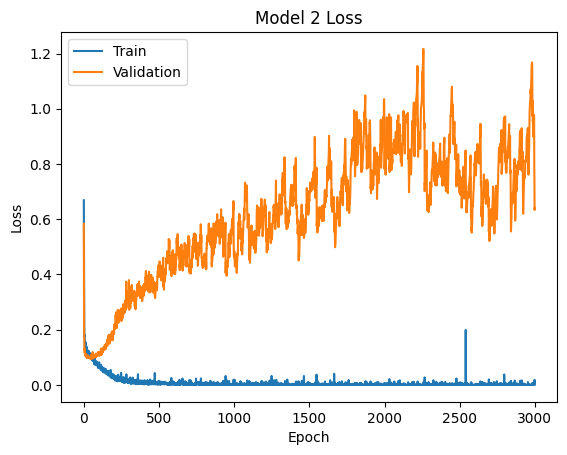

/home/gino/miniconda3/envs/tf/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Fold 3
Confusion Matrix:
 [[334  15]
 [ 11 338]]

Classification Report:
               precision    recall  f1-score   support

         0.0       0.97      0.96      0.96       349
         1.0       0.96      0.97      0.96       349

    accuracy                           0.96       698
   macro avg       0.96      0.96      0.96       698
weighted avg       0.96      0.96      0.96       698



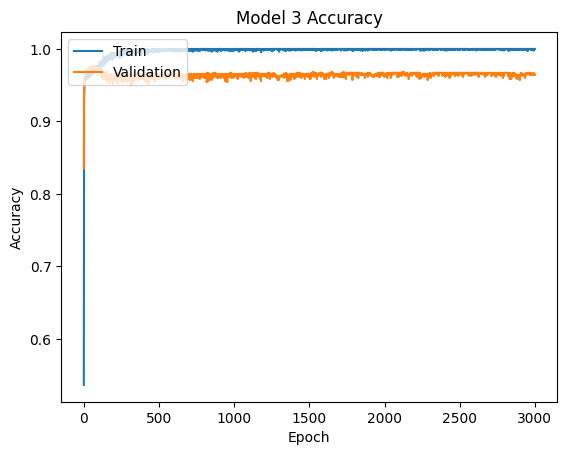

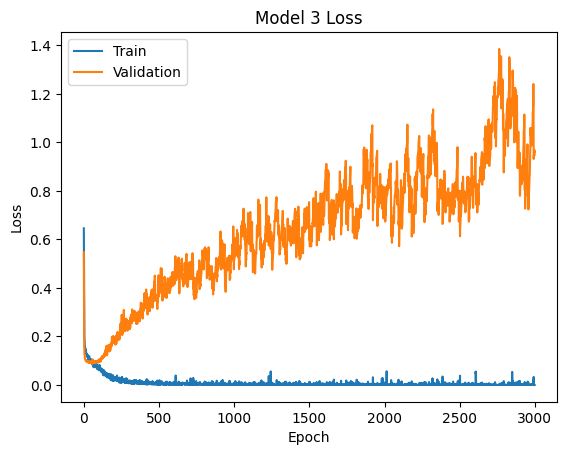

/home/gino/miniconda3/envs/tf/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Fold 4
Confusion Matrix:
 [[334  15]
 [ 15 334]]

Classification Report:
               precision    recall  f1-score   support

         0.0       0.96      0.96      0.96       349
         1.0       0.96      0.96      0.96       349

    accuracy                           0.96       698
   macro avg       0.96      0.96      0.96       698
weighted avg       0.96      0.96      0.96       698



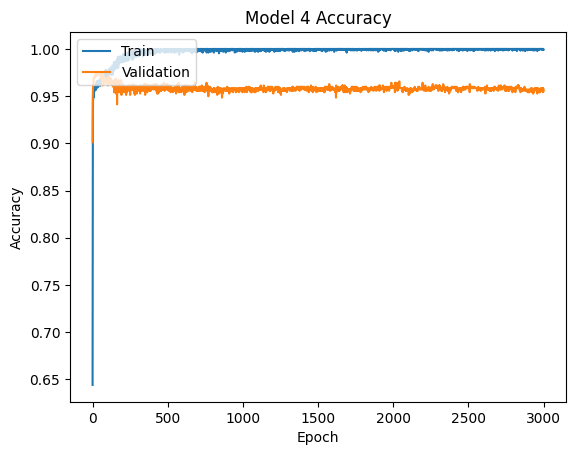

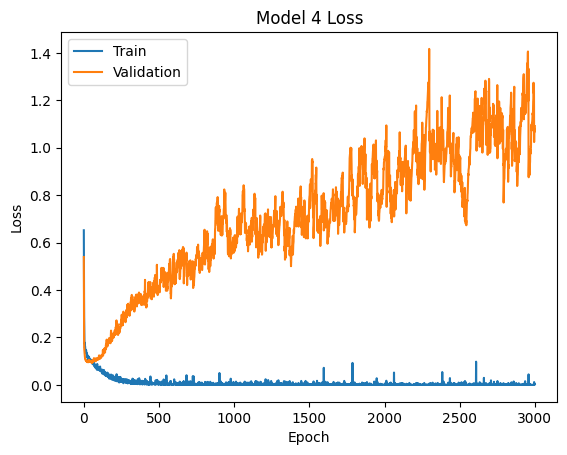

In [13]:
from keras import Sequential
from keras.api.layers import Dense, Dropout
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix


accuracy_scores = []
i = 0
for train_index, test_index in skf.split(X_train_resampled, y_train_resampled):
    X_train_fold, X_test_fold = X_train_resampled[train_index], X_train_resampled[test_index]
    y_train_fold, y_test_fold = y_train_resampled[train_index], y_train_resampled[test_index]
    model = Sequential([
        Dense(1024, activation='relu', input_shape=(X_train.shape[1],)),
        Dropout(0.5),
        Dense(512, activation='relu'),
        Dropout(0.4),
        Dense(256, activation='relu'),
        Dropout(0.3),
        Dense(128, activation='relu'),
        Dropout(0.3),
        Dense(64, activation='relu'),
        Dropout(0.2),
        Dense(32, activation='relu'),
        Dropout(0.1),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer=keras.api.optimizers.Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])
    
    from keras.api.callbacks import ModelCheckpoint
    checkpoint = ModelCheckpoint(f'model_{i}.keras', save_best_only=True)
    
    # Train the model
    history = model.fit(X_train_fold, y_train_fold, epochs=3000, batch_size=16, verbose=0, callbacks=[checkpoint], validation_data=(X_test, y_test))

    # Evaluate the model
    y_pred = (model.predict(X_test) > 0.6).astype("int32")
    accuracy = accuracy_score(y_test, y_pred)
    accuracy_scores.append(accuracy)

    cm = confusion_matrix(y_test, y_pred)
    cr = classification_report(y_test, y_pred)
    print(f"Fold {i}")
    print("Confusion Matrix:\n", cm)
    print("\nClassification Report:\n", cr)
    
    
    import matplotlib.pyplot as plt
    
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title(f'Model {i} Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()
    
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title(f'Model {i} Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    
    plt.show()
    i += 1

In [14]:
mean_accuracy = np.mean(accuracy_scores)
std_accuracy = np.std(accuracy_scores)

print(f"Mean Accuracy: {mean_accuracy:.4f}")
print(f"Standard Deviation of Accuracy: {std_accuracy:.4f}")


Mean Accuracy: 0.9613
Standard Deviation of Accuracy: 0.0042


In [15]:
# loss, accuracy = model.evaluate(X_test, y_test)
# print(f'Test Accuracy: {accuracy:.4f}')
# print(f'Test Loss: {loss:.4f}')

In [16]:
# from sklearn.metrics import confusion_matrix, classification_report
# y_pred = (model.predict(X_test) > 0.6).astype("int32")
# cm = confusion_matrix(y_test, y_pred)
# cr = classification_report(y_test, y_pred)
# print("Confusion Matrix:\n", cm)
# print("\nClassification Report:\n", cr)

In [17]:
# # visualize loss and accuracy in plots
# import matplotlib.pyplot as plt
# 
# plt.plot(history.history['accuracy'])
# plt.plot(history.history['val_accuracy'])
# plt.title('Model Accuracy')
# plt.ylabel('Accuracy')
# plt.xlabel('Epoch')
# plt.legend(['Train', 'Validation'], loc='upper left')
# plt.show()


In [18]:

# plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
# plt.title('Model Loss')
# plt.ylabel('Loss')
# plt.xlabel('Epoch')
# plt.legend(['Train', 'Validation'], loc='upper left')
# 
# plt.show()